# Behavioral analysis

In this notebook we run a various analyses around the behavioral data collected during the simulation (responses to intitial survey and actions during the simulations). This includes the calculation of assortativty with respect to these features.

In [1]:
import os
import math
from os import path
import pickle
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import networkx as nx

from utils.plotting import color_graph_by_attribute
from utils.assortativity import calc_weighted_attrib_assortativity, calc_weighted_attrib_assortativity_sig

In [2]:
data_folder = "./data"
output_folder = "./output"
if not path.exists(output_folder):
    os.makedirs(output_folder)

In [3]:
# Set a random seed for reproducibility
random_seed = 32
random.seed(random_seed)

with open(path.join(data_folder, 'network-largest_conn_comp.pickle'), 'rb') as f:
    G = pickle.load(f)

with open(path.join(data_folder, 'network-node-positions.pickle'), 'rb') as f:
    Gpos = pickle.load(f)

with open(path.join(data_folder, 'user_prefs.pickle'), 'rb') as f:
    user_prefs = pickle.load(f)

with open(path.join(data_folder, 'user_prefs_all.pickle'), 'rb') as f:
    user_prefs_all = pickle.load(f)

with open(path.join(data_folder, 'daily-behaviors.pickle'), 'rb') as f:
    daily_behaviors = pickle.load(f)

weights = list(nx.get_edge_attributes(G, 'weight').values())
wmin = np.min(weights)/2
wmax = np.max(weights)
edge_weights = [pow((w - wmin)/(wmax-wmin), 0.35) for w in weights] 

In [4]:
questions = ["Public health officials should have the power to order people\ninto quarantine during COVID-19 outbreaks",
             "If someone is given a quarantine order by a public health official, they should\nfollow it no matter what else is going on in their life at work or home",
             "If I go into quarantine, my family, friends, and community will be protected\nfrom getting COVID-19"]
qresponses = ["Strongly disagree", "Somewhat agree", "Neither agree or disagree", "Somewhat agreee", "Strongly agree"]

demographics = ['Gender', 'Major', 'Year', 'Mobile Operating System']
gender_labels = ['Female', 'Male', 'Other']
major_labels = ['Biological Science', 'Business', 'Chemistry', 'Communication', 'Computer Science', 
                'Design', 'English', 'Mathematics and applied Mathematics', 'Psychology']
year_labels = ['Freshman', 'Sophomore', 'Junior',  'Senior']
mos_labels = ['Android', 'iOS', 'HarmonyOS (Huawei)']
labels = dict(zip(demographics, [gender_labels, major_labels, year_labels, mos_labels]))

qpref_vars = ['q1_response', 'q2_response', 'q3_response']
demo_vars = ['gender', 'major', 'year', 'mobile_os']
action_vars = ['quarantine_yes', 'quarantine_no', 'quarantine_ratio', 'wear_mask', 'num_contacts']
attribs = demo_vars + action_vars + qpref_vars

## Charts showing participants' basic demographics

This comprises gender, major, year, and mobile operating system.

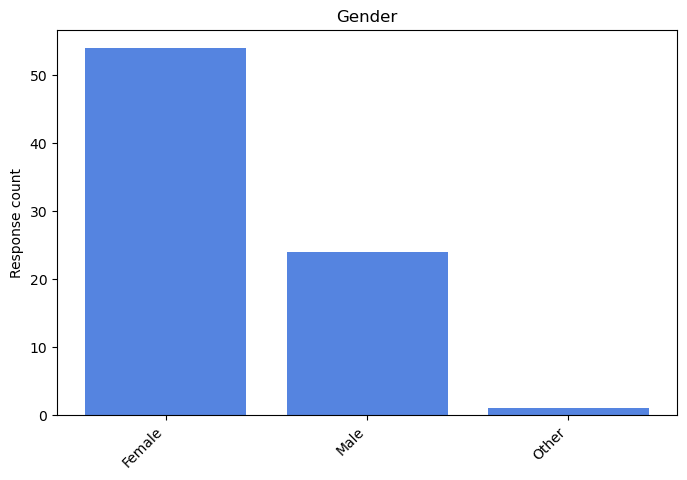

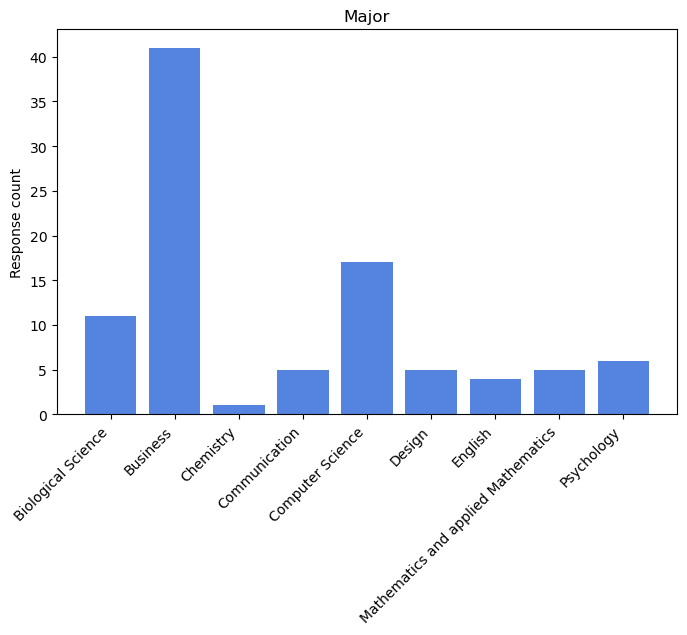

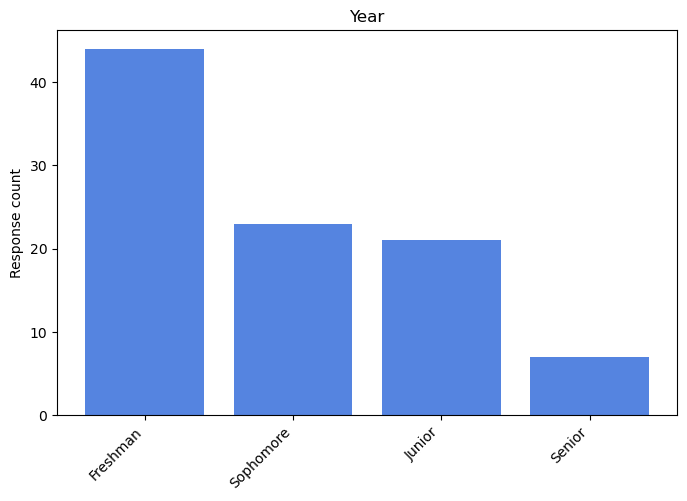

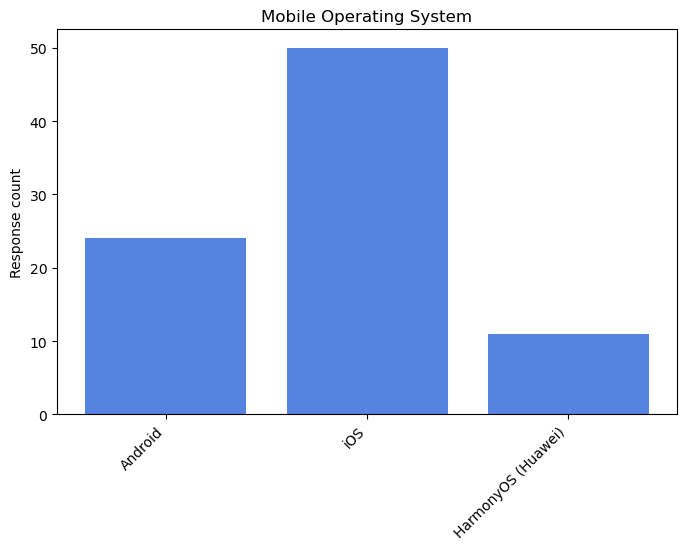

In [5]:
df = user_prefs_all
print()
for d, v in zip(demographics, demo_vars):     
    counts = df[v].value_counts().sort_index()
    plt.figure(figsize=(8, 5))
    plt.bar(labels[d], counts, color='#5584E0')
    plt.xticks(rotation=45, ha='right')
    plt.title(d)
    plt.ylabel('Response count')
    plt.savefig(path.join(output_folder, 'survey-' + v + '.png'), bbox_inches='tight')
    plt.show()    

## Charts showing participants' survey responses and choices during the simulation

This comprises the responses to the questions regarding attitudes about quarantine, and daily counts of quarantine and mask purchase.

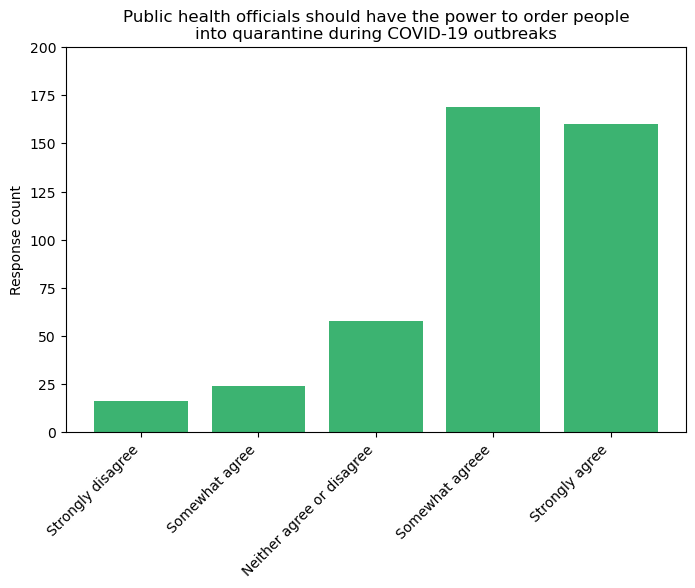

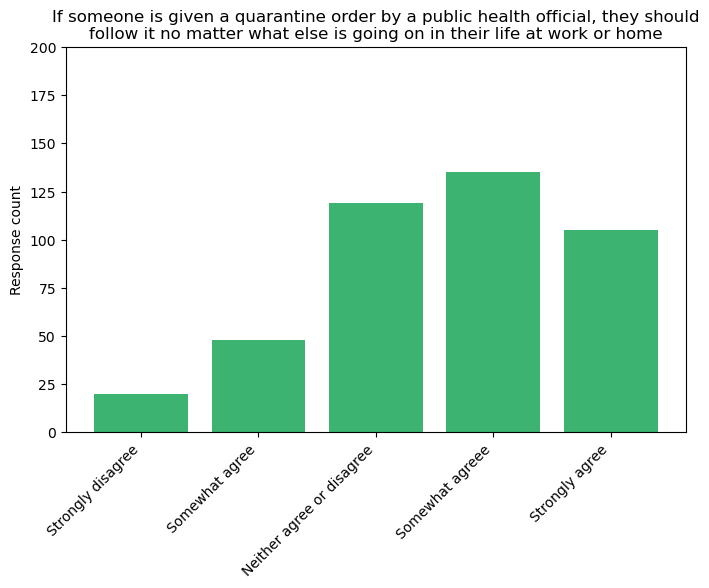

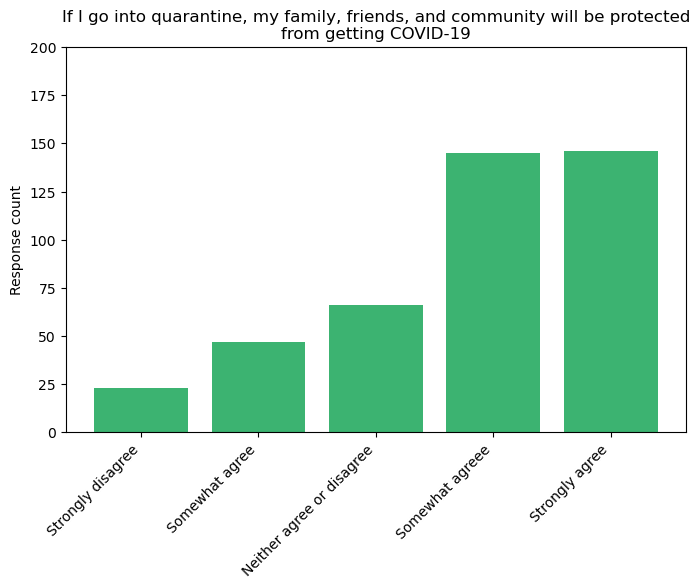

In [6]:
df = user_prefs_all
maxc = 200
for q, v in zip(questions, qpref_vars):     
    counts = df[v].value_counts().sort_index()
    plt.figure(figsize=(8, 5))
    plt.bar(qresponses, counts, color='#3cb371')
    plt.xticks(rotation=45, ha='right')
    plt.title(q)
    plt.ylim(0, maxc)
    plt.ylabel('Response count')
    plt.savefig(path.join(output_folder, 'survey-' + v + '.png'), bbox_inches='tight')
    plt.show()    

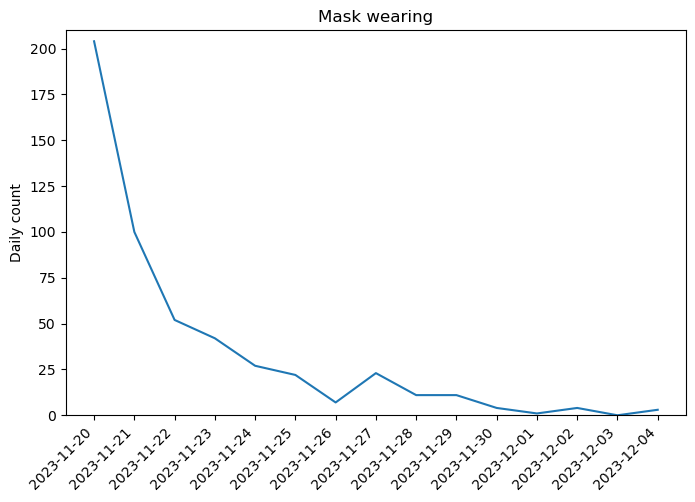

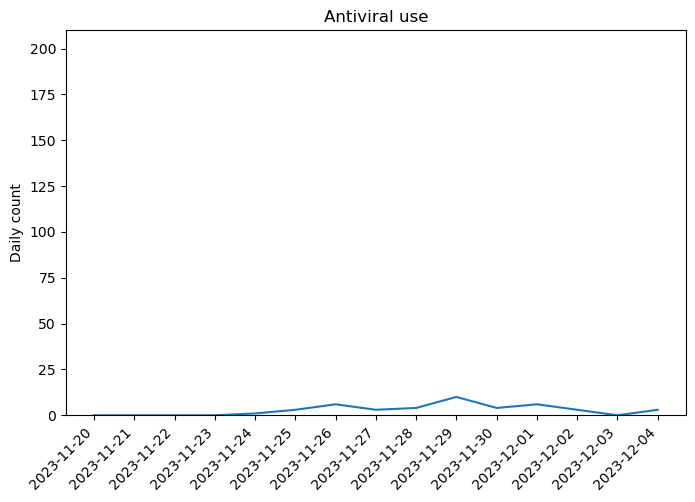

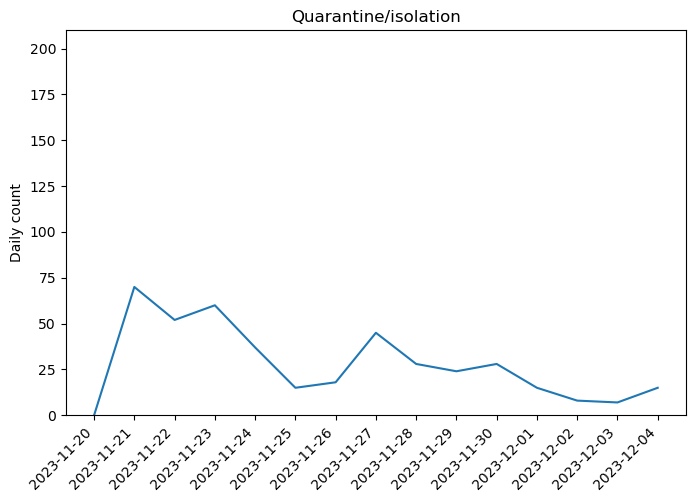

In [7]:
behaviors = ['masking', 'medication', 'quarantine_yes']
titles = ['Mask wearing', 'Antiviral use', 'Quarantine/isolation']
maxc = 210
for b, t in zip(behaviors, titles):
    plt.figure(figsize=(8, 5))
    plt.plot(daily_behaviors['date'], daily_behaviors[b])
    plt.xticks(rotation=45, ha='right')
    plt.title(t)
    plt.ylim(0, maxc)
    plt.ylabel('Daily count')
    plt.savefig(path.join(output_folder, 'daily-behavior-' + b + '.png'), bbox_inches='tight')
    plt.show()       

## Correlation between action and quarantine perception and demographic variables

Here we examine if there are any correlation between how students responded to the survey on quarantine perceptions, and their choices during the simulation (quarantine yes/no, wearing mask, level of interaction). 

We generate the distribution of the variables quantifying these choices (i.e: number of times the student chose to quarantine) conditioned by their response to each one of the three survey questions. We can explore these distributions visually using the plots below, and then calculate if they are statistically different using the [one-way ANOVA test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html) or the [Kruskal-Wallis test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html) (picking one or the other depends on whether the distributions are normal and have homogeneous variances). 

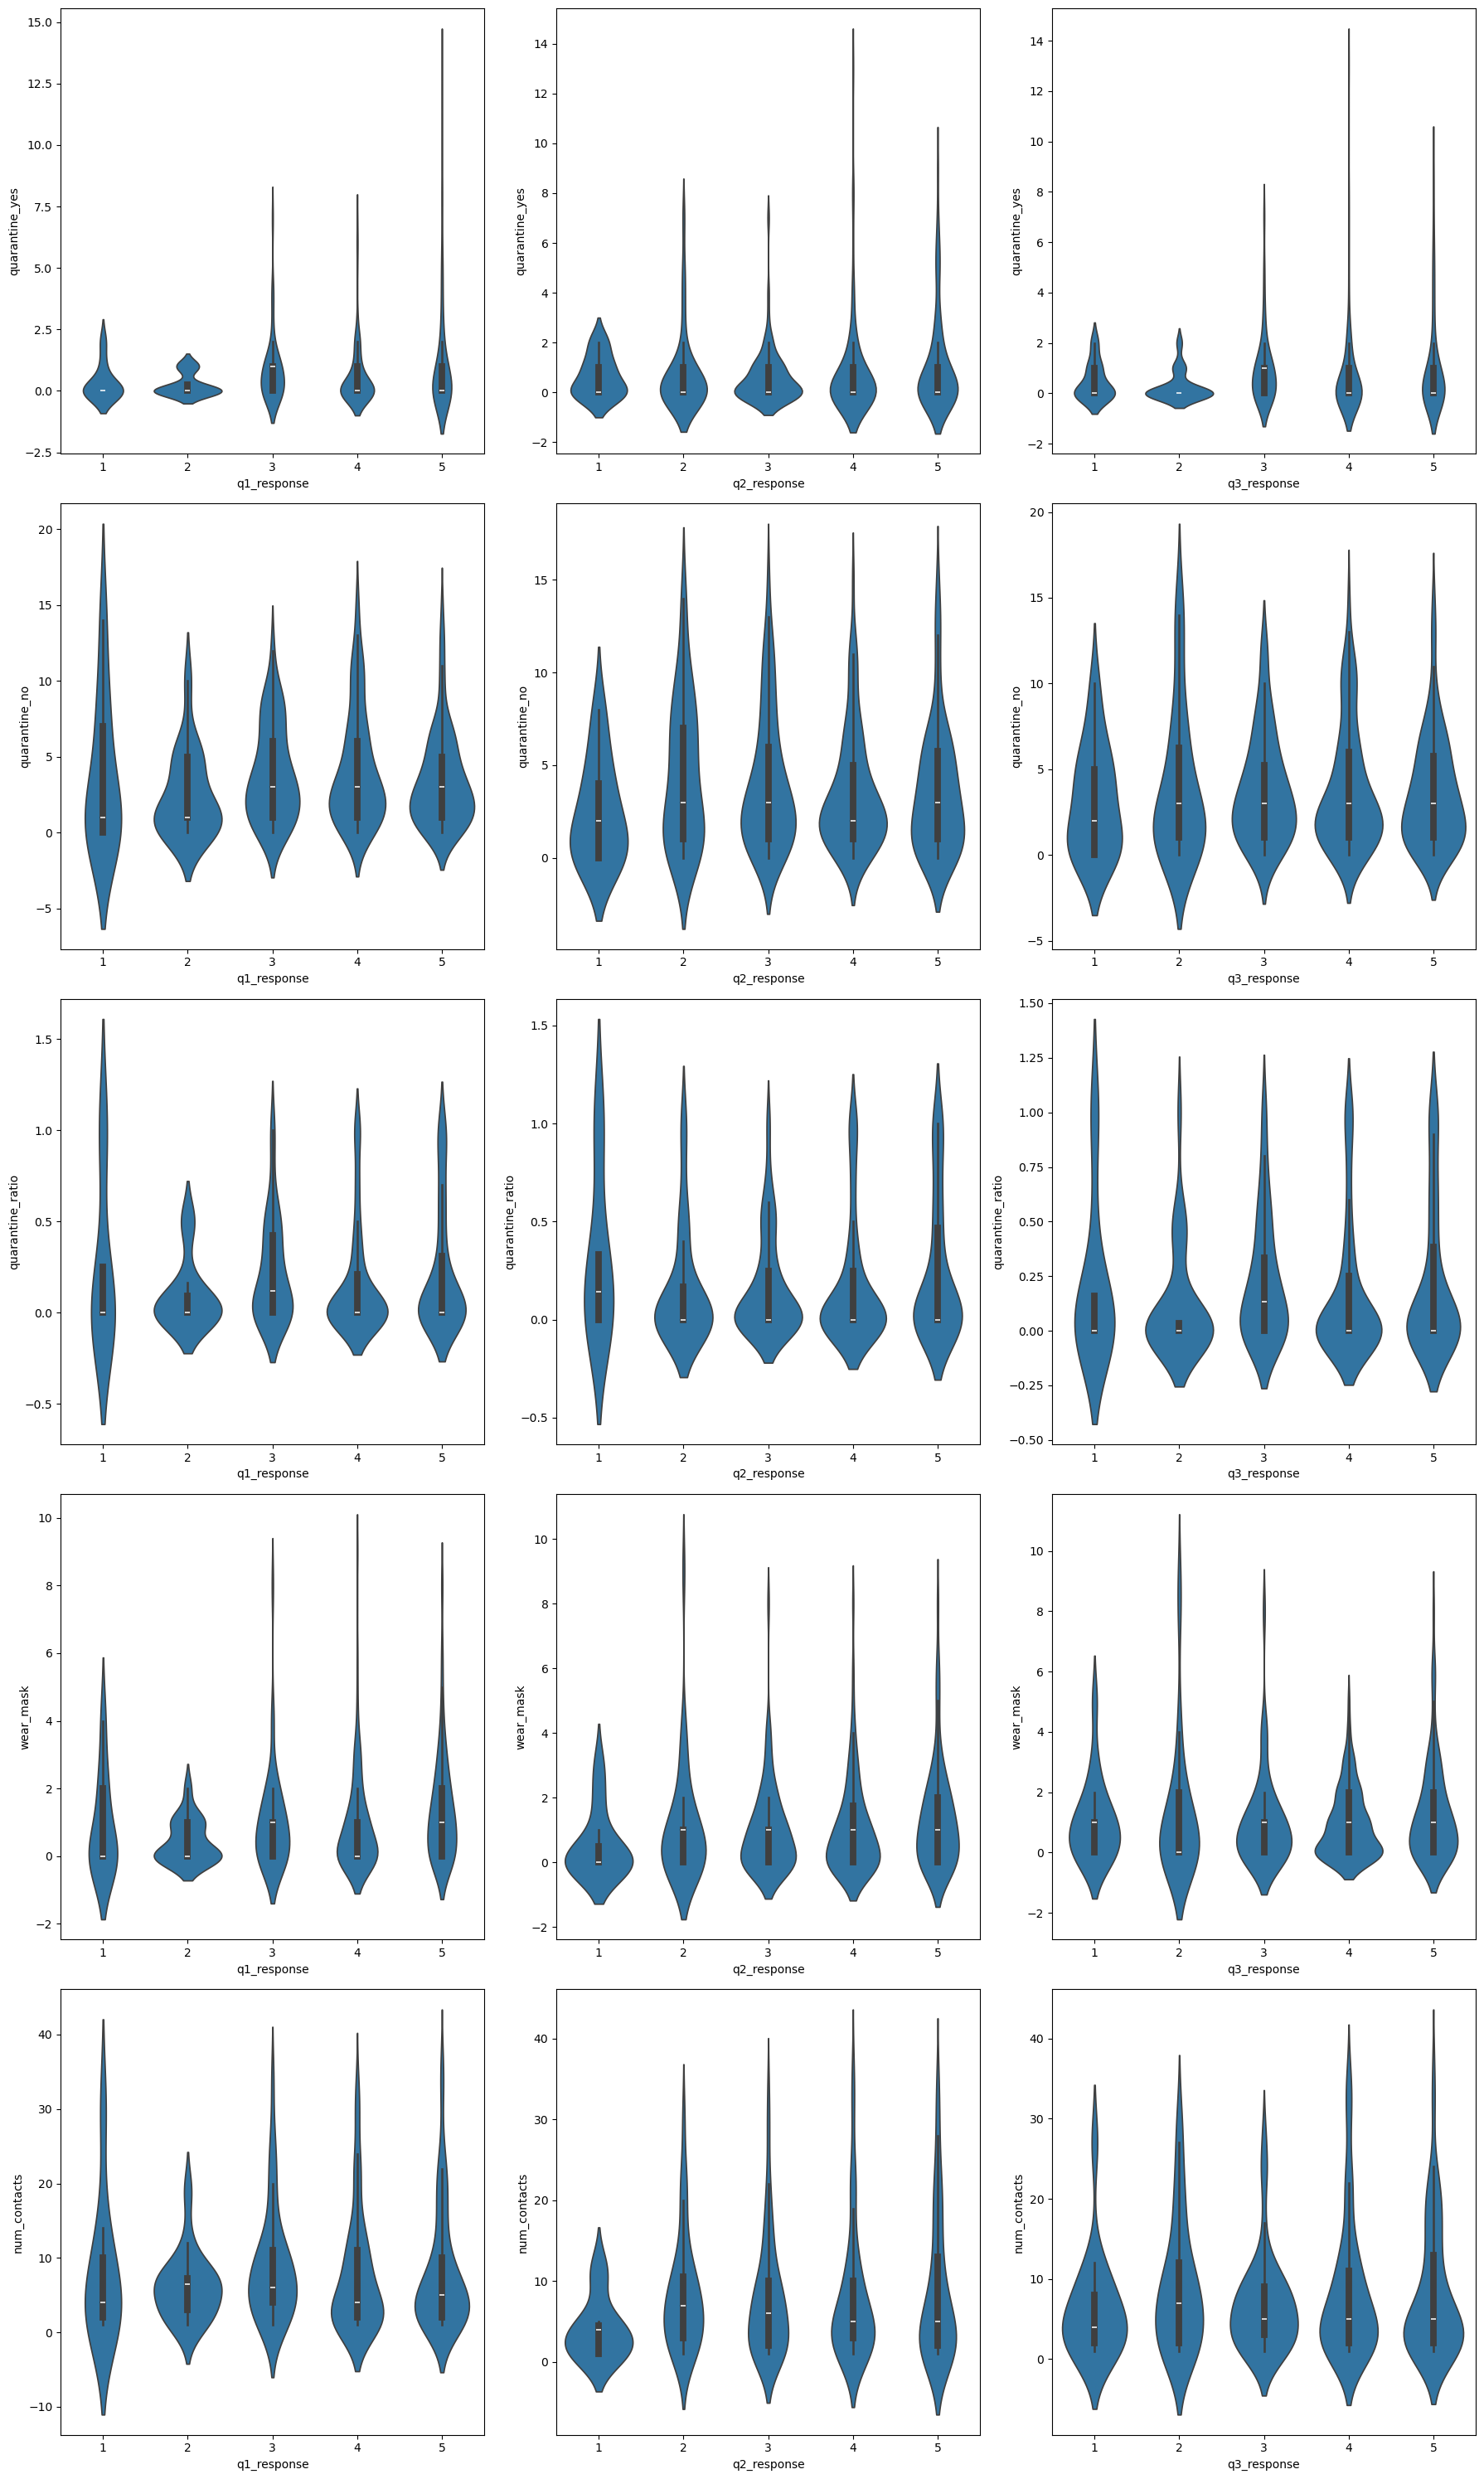

In [8]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=[18, 30])
for avar in action_vars:
    for dvar in qpref_vars:    
        axis = axs[action_vars.index(avar), qpref_vars.index(dvar)]
        sns.violinplot(x=dvar, y=avar, data=user_prefs, ax=axis)
        axis.set_xticks([0, 1, 2, 3, 4], ['1', '2', '3', '4', '5'])
fig.tight_layout()
plt.show()

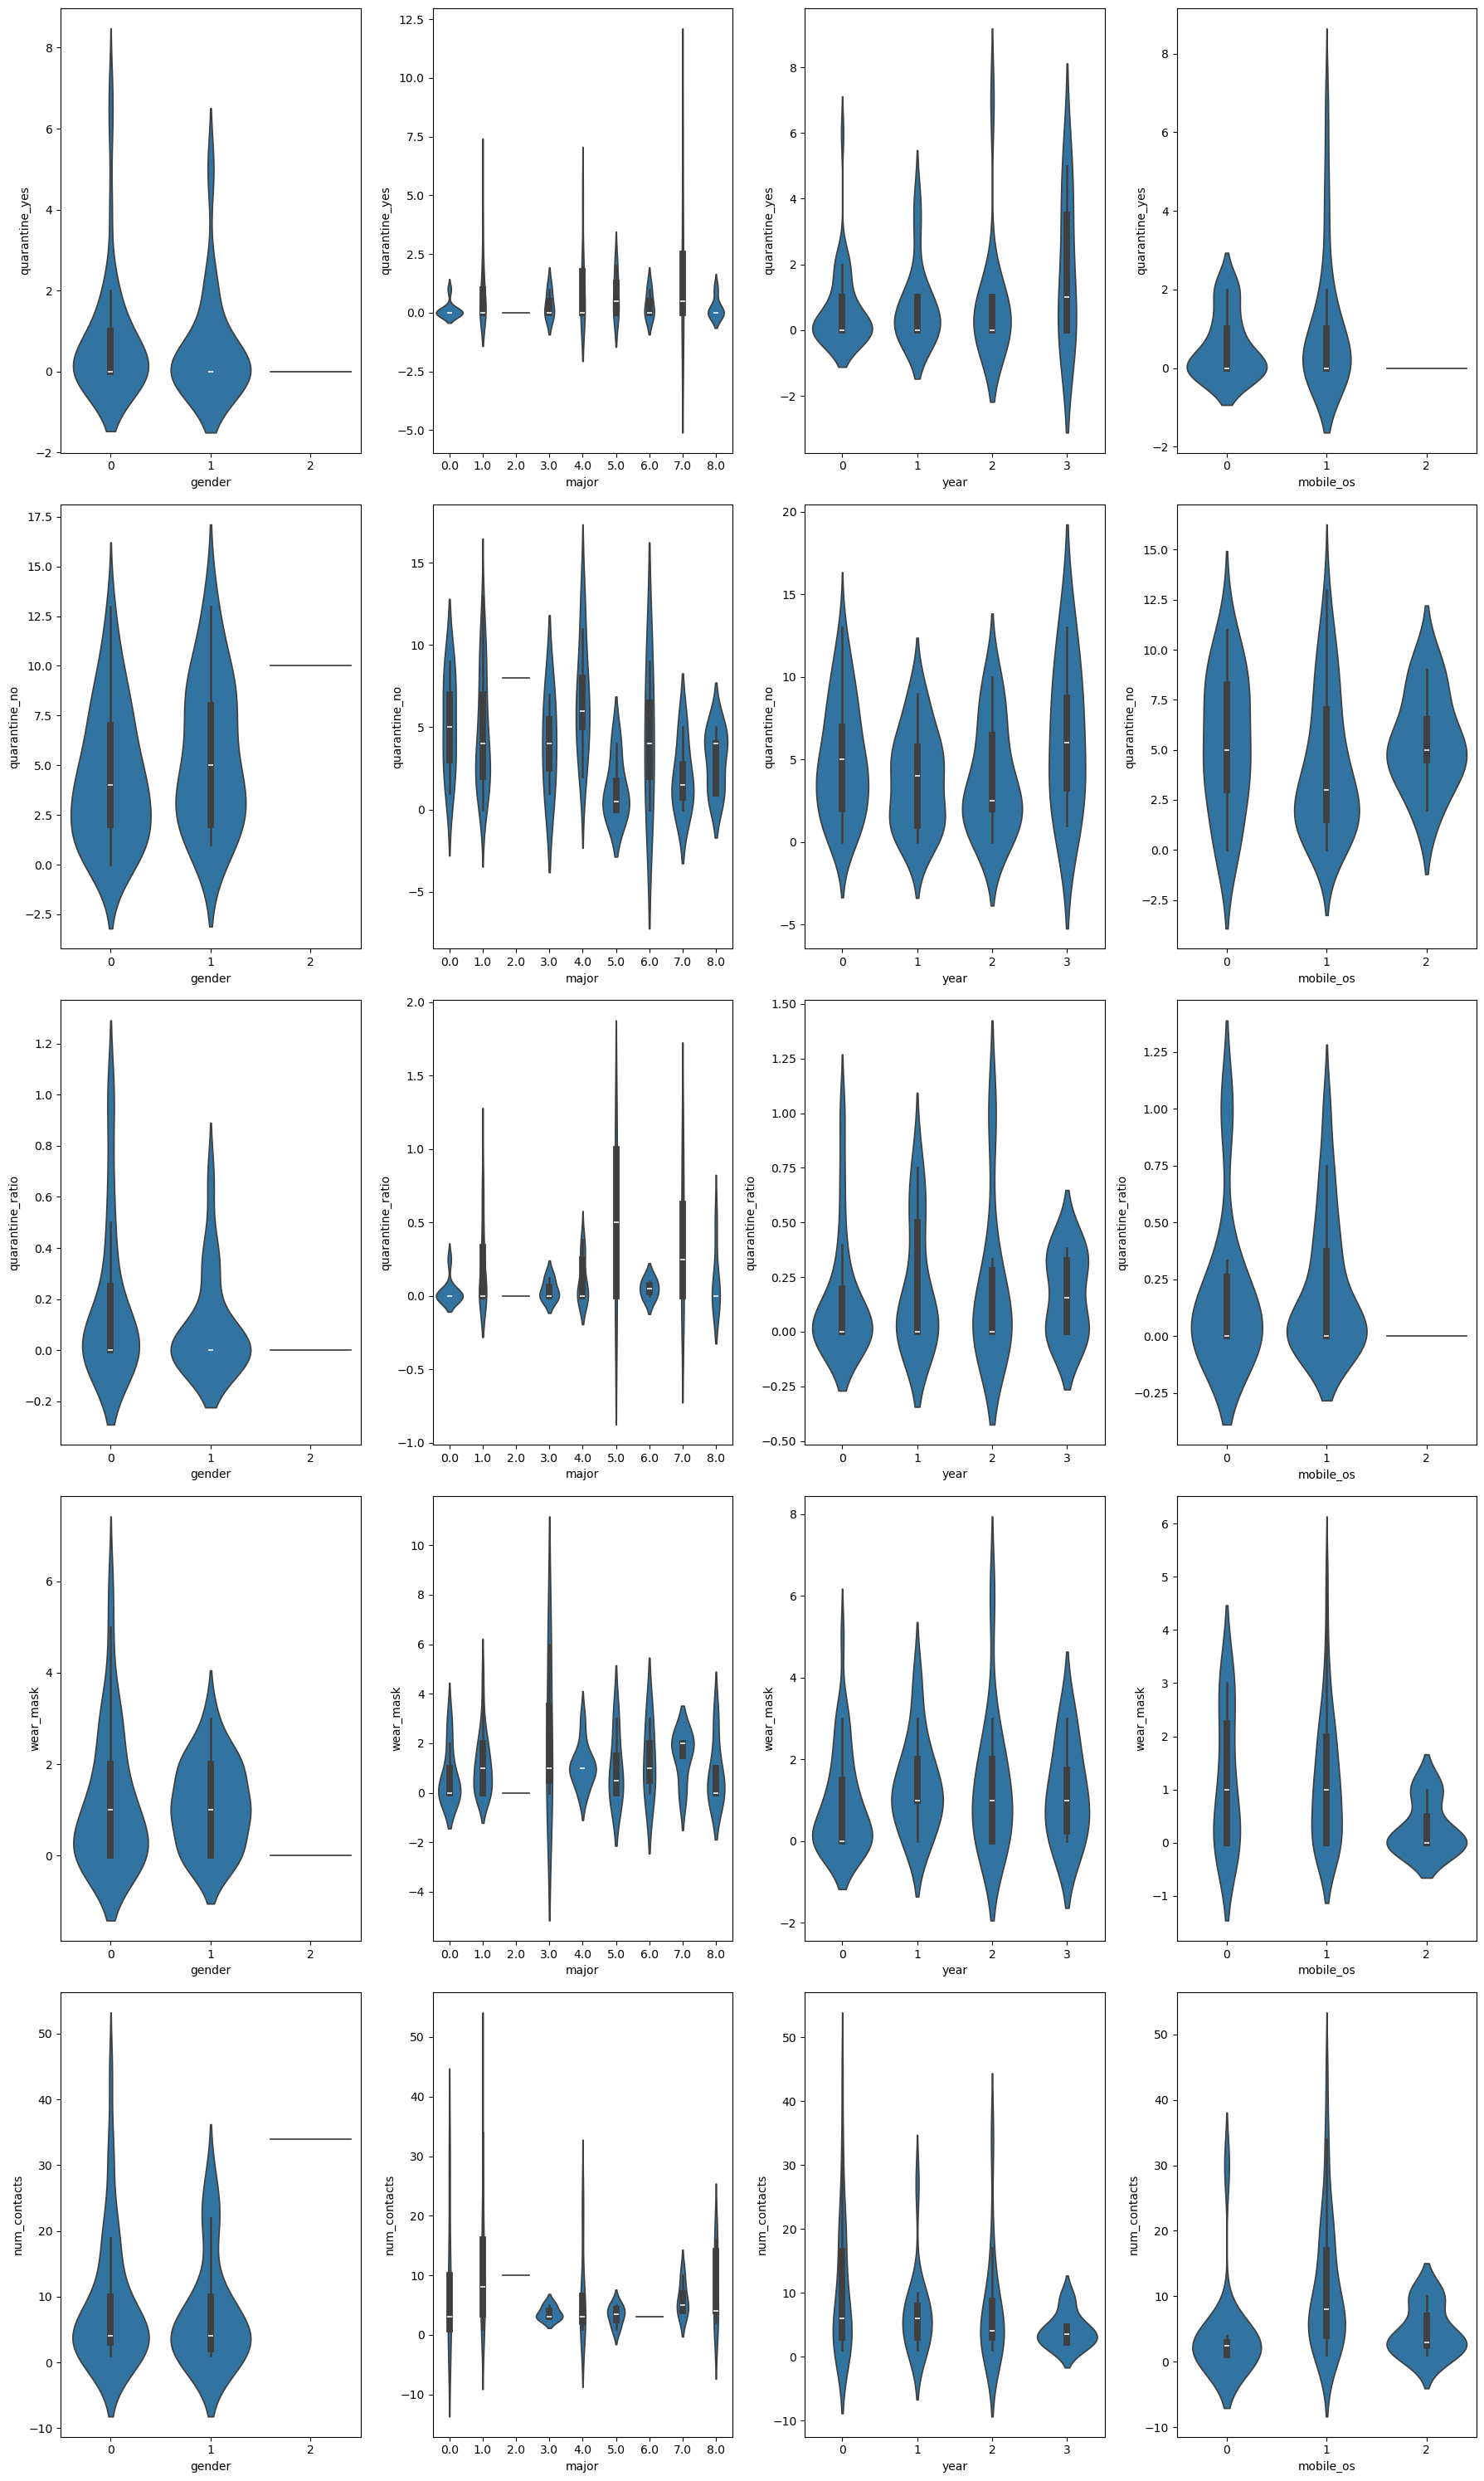

In [9]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[18, 30])
for avar in action_vars:
    for dvar in demo_vars:    
        axis = axs[action_vars.index(avar), demo_vars.index(dvar)]
        df = user_prefs[[avar, dvar]].dropna()
        sns.violinplot(x=dvar, y=avar, data=df, ax=axis)
fig.tight_layout()
plt.show()

In [10]:
# Significance level for Normality Check and Homogeneity of Variances Check. If those fail, then
# Kruskal-Wallis Test is used because is a a non-parametric alternative to one-way ANOVA and that 
# can be applied when the assumptions of ANOVA (normality and homogeneity of variances) are not met.
sig_level = 0.05

def convert_to_int(lst):
    numbers = [x for x in lst if isinstance(x, (int, float, np.integer, np.floating)) and not np.isnan(x)]
    integers = list(map(int, filter(lambda x: not np.isnan(x), numbers)))
    integers.sort()
    return integers

def check_association(avar, cvar):
    print(avar, 'AND', cvar)
    
    # Get unique values in cvar
    unique_values = convert_to_int(user_prefs[cvar].unique())

    # Create groups for each unique value in cvar
    groups = [user_prefs[user_prefs[cvar] == val][avar].dropna() for val in unique_values]
        
    # Normality check
    normality_tests = [stats.shapiro(group) for group in groups]
    pnorm_values = [test[1] for test in normality_tests]
        
    # Homogeneity of variances check
    _, phom = stats.levene(*groups)

    anova_assumptions_valid = all(p > sig_level for p in pnorm_values) and phom > sig_level        
    if anova_assumptions_valid:
        f_statistic, p_value_fstat = stats.f_oneway(*groups)
        print(f'  Statistic for one-way ANOVA Test = {f_statistic:.2f} (p-value = {p_value_fstat:.2f})')
    else:
        h_statistic, p_value_hstat = stats.kruskal(*groups)
        print(f'  Statistic for Kruskal-Wallis Test = {h_statistic:.2f} (p-value = {p_value_hstat:.2f})')

for avar in action_vars:
    for qvar in qpref_vars:
        check_association(avar, qvar)

print()
for avar in action_vars:
    for dvar in demo_vars:
        check_association(avar, dvar)

print()
for qvar in qpref_vars:
    for dvar in demo_vars:
        check_association(qvar, dvar)

quarantine_yes AND q1_response
  Statistic for Kruskal-Wallis Test = 7.46 (p-value = 0.11)
quarantine_yes AND q2_response
  Statistic for Kruskal-Wallis Test = 2.44 (p-value = 0.66)
quarantine_yes AND q3_response
  Statistic for Kruskal-Wallis Test = 10.97 (p-value = 0.03)
quarantine_no AND q1_response
  Statistic for Kruskal-Wallis Test = 5.97 (p-value = 0.20)
quarantine_no AND q2_response
  Statistic for Kruskal-Wallis Test = 3.62 (p-value = 0.46)
quarantine_no AND q3_response
  Statistic for Kruskal-Wallis Test = 1.12 (p-value = 0.89)
quarantine_ratio AND q1_response
  Statistic for Kruskal-Wallis Test = 6.36 (p-value = 0.17)
quarantine_ratio AND q2_response
  Statistic for Kruskal-Wallis Test = 4.24 (p-value = 0.37)
quarantine_ratio AND q3_response
  Statistic for Kruskal-Wallis Test = 8.29 (p-value = 0.08)
wear_mask AND q1_response
  Statistic for Kruskal-Wallis Test = 13.77 (p-value = 0.01)
wear_mask AND q2_response
  Statistic for Kruskal-Wallis Test = 6.55 (p-value = 0.16)
wear

/var/folders/fx/4vw55n6x3hl1z2_jgmncv3680000gn/T/ipykernel_3869/1058424290.py:22: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  normality_tests = [stats.shapiro(group) for group in groups]
/Users/andres/miniconda3/envs/pyenv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [11]:
df_clean = user_prefs.dropna()
corr = df_clean.corr(method='kendall')
corr

,quarantine_yes,quarantine_no,quarantine_ratio,wear_mask,q1_response,q2_response,q3_response,gender,major,year,mobile_os,num_contacts
quarantine_yes,1.000000,-0.233094,0.870494,0.314478,0.216836,0.055033,0.156043,-0.120711,0.126265,-0.097218,-0.054287,0.237287
quarantine_no,-0.233094,1.000000,-0.351560,-0.150282,-0.065718,-0.163162,-0.018909,0.182144,-0.055910,-0.027243,-0.062631,-0.097945
quarantine_ratio,0.870494,-0.351560,1.000000,0.290404,0.129872,0.036551,0.145911,-0.144345,0.133108,-0.089728,-0.075052,0.199142
wear_mask,0.314478,-0.150282,0.290404,1.000000,0.283922,0.093708,0.093865,0.034714,0.137044,0.082498,-0.089412,0.175926
q1_response,0.216836,-0.065718,0.129872,0.283922,1.000000,0.535768,0.293467,-0.275224,0.258901,0.161075,-0.123912,0.102517
q2_response,0.055033,-0.163162,0.036551,0.093708,0.535768,1.000000,0.317502,0.061263,0.117032,0.284776,-0.087150,-0.034401
q3_response,0.156043,-0.018909,0.145911,0.093865,0.293467,0.317502,1.000000,-0.108694,0.010846,0.008487,-0.211718,-0.086658
gender,-0.120711,0.182144,-0.144345,0.034714,-0.275224,0.061263,-0.108694,1.000000,-0.044179,0.034573,0.037471,0.050939
major,0.126265,-0.055910,0.133108,0.137044,0.258901,0.117032,0.010846,-0.044179,1.000000,-0.050979,0.042927,0.011443
year,-0.097218,-0.027243,-0.089728,0.082498,0.161075,0.284776,0.008487,0.034573,-0.050979,1.000000,0.030885,-0.112349


## Assortativity with node properties

[Assortativity](https://ona-book.org/similarity.html) measures how a certain property of the nodes is postively (or negatively) associated with the tendency of the nodes to be connected; in other words, individuals interact (avoid) more with similar (different) people. 

In our analysis, we calculate assortativity with respect to the behavioral attributes we collected in the dataset:

In [12]:
# Assortativity calculation using the DescrStatsW from statsmodels.stats.weightstats
# and the p-value using bootstrapping
for attrib in attribs:
    print(attrib)
    rho = calc_weighted_attrib_assortativity(G, attrib)
    pval = calc_weighted_attrib_assortativity_sig(G, attrib, rho, 10000)
    print(f'Assortativity value for {attrib} = {rho:.2f} (p-value = {pval:.2f})')

gender
Assortativity value for gender = 0.29 (p-value = 0.16)
major
Assortativity value for major = 0.65 (p-value = 0.01)
year
Assortativity value for year = 0.81 (p-value = 0.00)
mobile_os
Assortativity value for mobile_os = 0.08 (p-value = 0.29)
quarantine_yes
Assortativity value for quarantine_yes = 0.10 (p-value = 0.20)
quarantine_no
Assortativity value for quarantine_no = 0.17 (p-value = 0.17)
quarantine_ratio
Assortativity value for quarantine_ratio = 0.15 (p-value = 0.12)
wear_mask
Assortativity value for wear_mask = 0.23 (p-value = 0.07)
num_contacts
Assortativity value for num_contacts = 0.31 (p-value = 0.05)
q1_response
Assortativity value for q1_response = 0.14 (p-value = 0.23)
q2_response
Assortativity value for q2_response = 0.36 (p-value = 0.05)
q3_response
Assortativity value for q3_response = 0.25 (p-value = 0.12)


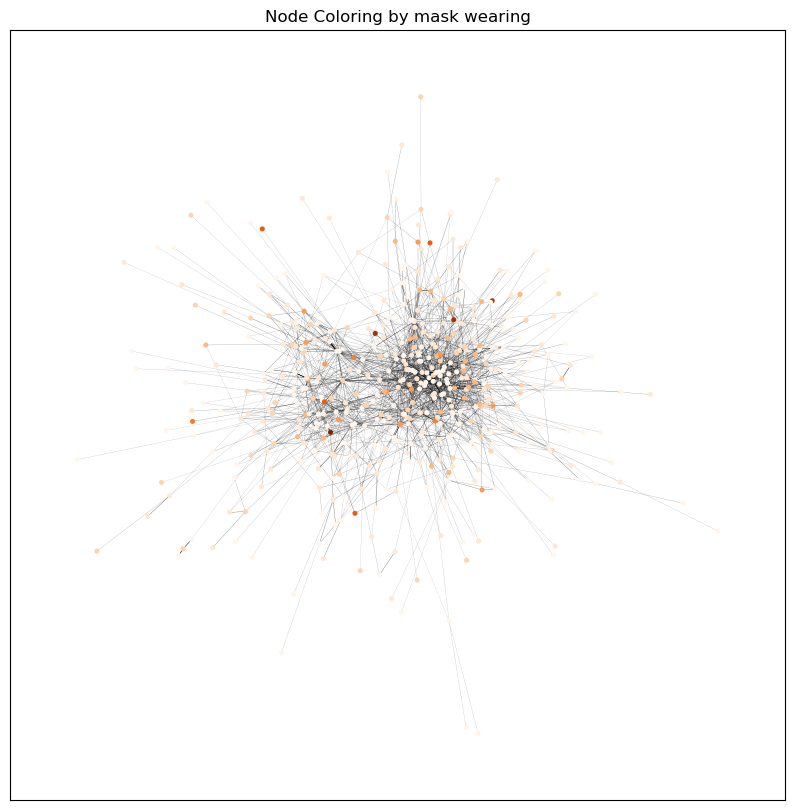

In [13]:
wm_dict = nx.get_node_attributes(G, 'wear_mask')
wm_attrib = [wm_dict[idx] for idx in wm_dict]
color_graph_by_attribute(G, Gpos, wm_attrib, 'Node Coloring by mask wearing', edge_weights)

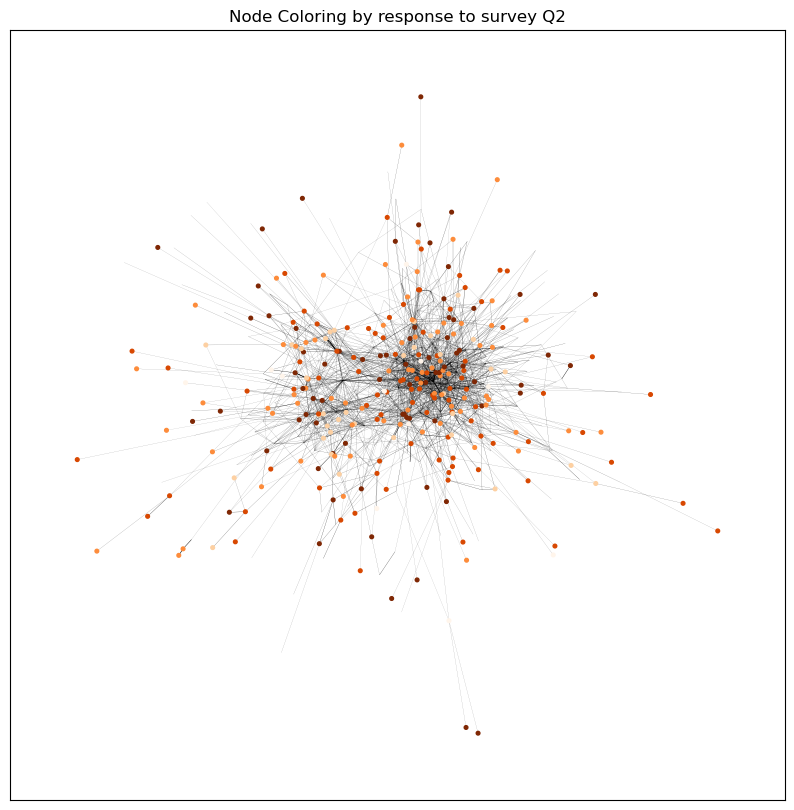

In [14]:
q2_dict = nx.get_node_attributes(G, 'q2_response')
q2_attrib = [q2_dict[idx] for idx in q2_dict]
color_graph_by_attribute(G, Gpos, q2_attrib, 'Node Coloring by response to survey Q2', edge_weights)

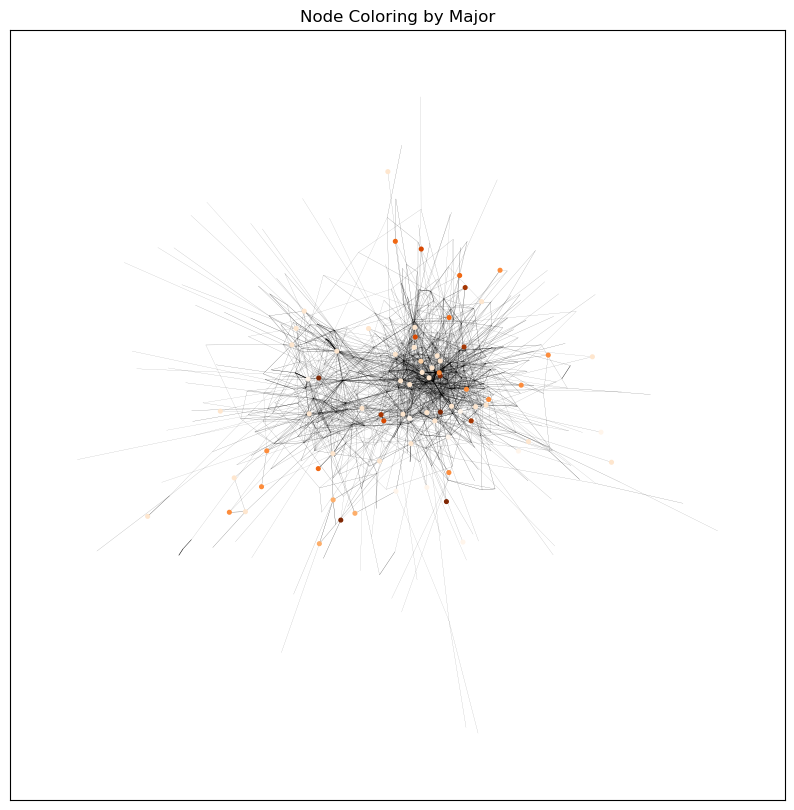

In [15]:
wm_dict = nx.get_node_attributes(G, 'major')
wm_attrib = [wm_dict[idx] for idx in wm_dict]
color_graph_by_attribute(G, Gpos, wm_attrib, 'Node Coloring by Major', edge_weights)

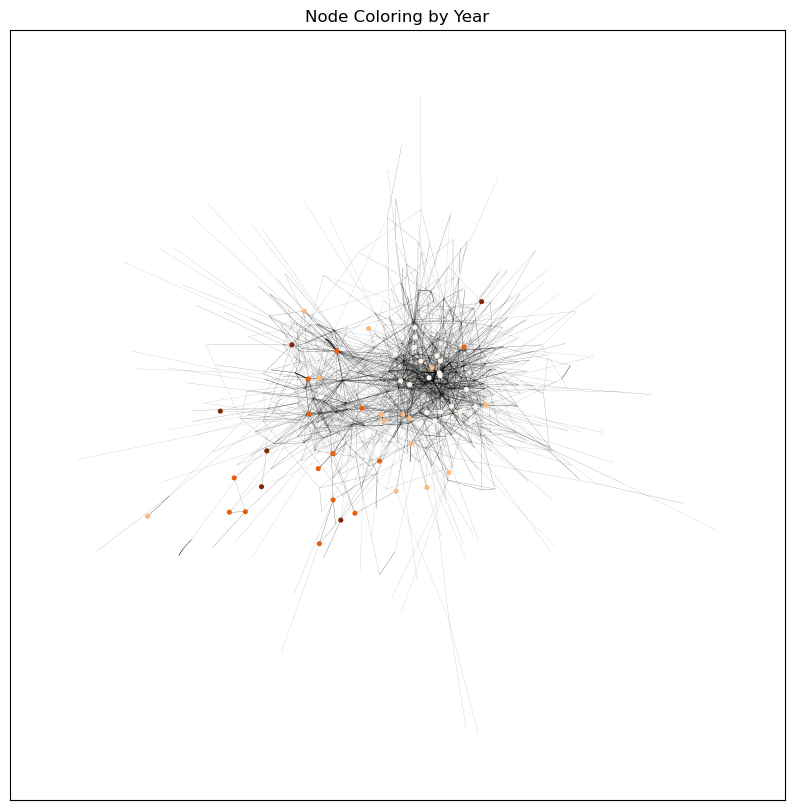

In [16]:
wm_dict = nx.get_node_attributes(G, 'year')
wm_attrib = [wm_dict[idx] for idx in wm_dict]
color_graph_by_attribute(G, Gpos, wm_attrib, 'Node Coloring by Year', edge_weights)